In [1]:
import matplotlib.pyplot as plt
import numpy as np
import deorbit
from deorbit.simulator.atmos import AtmosphereModel
from deorbit.simulator.atmos import get_available_atmos_models
from deorbit.data_models.atmos import get_model_for_atmos
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.coords import cart_from_latlong

This notebook exists to investigate the atmospheric models used within this project. 

Through generating a simulation instance we can see how the velocities in the atmosphere vary.

In [2]:
atmos = AtmosphereModel(get_model_for_atmos("coesa_atmos_fast")())

In [3]:
save_path = "eg/EKF_example_noise_2s/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

times = sim_data.times
sim_states = np.array(sim_data.state_array())
atmos_vel = np.array([atmos.velocity(sim_states[i], times[i]) for i in range(sim_states.shape[0])])

Loaded data from file


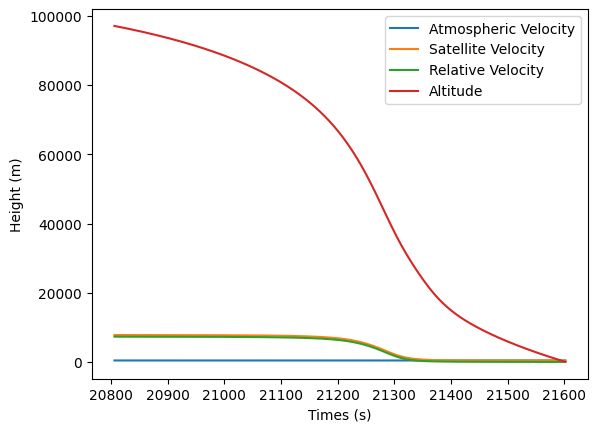

In [4]:
plot_range = slice(-400, -1) #plot end times only
#plot_range = slice(0, -1) #plot all times


fig, ax = plt.subplots()


ax.plot(times[plot_range], np.linalg.norm(atmos_vel, axis=1)[plot_range], label="Atmospheric Velocity")
ax.plot(times[plot_range], np.linalg.norm(sim_states[:, 2:], axis=1)[plot_range], label="Satellite Velocity")
ax.plot(times[plot_range], np.linalg.norm(sim_states[:, 2:] - atmos_vel, axis=1)[plot_range], label="Relative Velocity")
ax.plot(times[plot_range], (np.linalg.norm(sim_states[:, :2], axis=1) - deorbit.constants.EARTH_RADIUS)[plot_range], label="Altitude")
ax.set_xlabel('Times (s)')
ax.set_ylabel('Height (m)')
ax.legend()
plt.show()

The above plot can be used to investigate how the velocities vary with altitude.The atmospheric model used in the simulator can be varied to investigate the other models. We can further see how this varies with latitude.

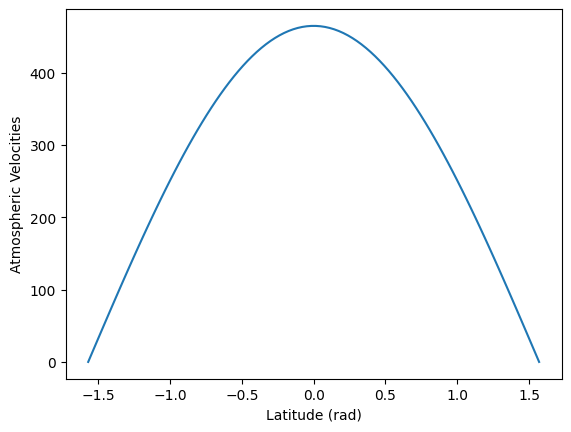

In [5]:
lat_points = np.linspace(-np.pi/2, np.pi/2, 100)
long = 0

meridian = np.array([cart_from_latlong((lat, long)) for lat in lat_points])

velocities = np.array([atmos.velocity(np.array([*m, 0, 0, 0]), 0) for m in meridian])

fig, ax = plt.subplots()
ax.plot(lat_points, np.linalg.norm(velocities, axis=1))
ax.set_xlabel('Latitude (rad)')
ax.set_ylabel('Atmospheric Velocities')
plt.show()

We can see how the density of the atmospheric models vary with height below.

In [6]:
height_bounds = (0,100000)
models = get_available_atmos_models()

C:\Users\court\Documents\masters\Group Project\mir-orbiter\src\deorbit\simulator\atmos.py:194: RuntimeWarning: overflow encountered in exp
  return self._density_at_max_height * np.exp(height - self._max_height)


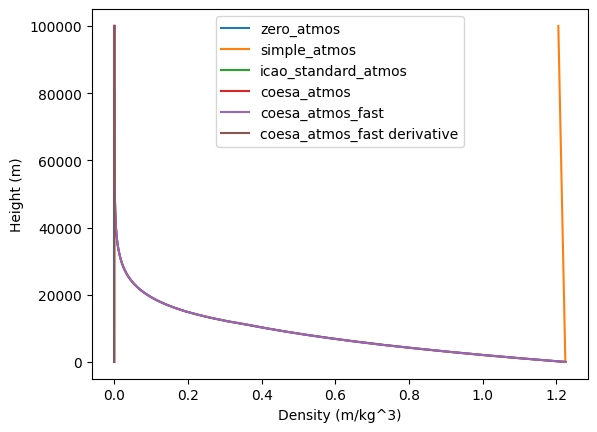

In [7]:
fig, ax = plt.subplots()
for model in models:
    model = AtmosphereModel(get_model_for_atmos(model)())
    model.plot(height_bounds, num_points=100, ax=ax, label=model.kwargs.atmos_name, derivative=True)
ax.legend()
ax.set_xlabel('Density (m/kg^3)')
ax.set_ylabel('Height (m)')
plt.show()